<a href="https://colab.research.google.com/github/Davjot/PlantDoc/blob/main/(bs%3D8%2Cdp%3D0_2%2Cepoch%3D200%2Ces~rm)SE_RAM_DN201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , TensorBoard
from tensorflow.keras.layers import Reshape, multiply, add, Conv2D, MaxPooling2D, BatchNormalization, Activation, ZeroPadding2D, AveragePooling2D

In [ ]:
# Set the batch size
batch_size = 8

# Set the number of epochs
epochs = 200

# Set the image size
img_size = 224

# Set the number of classes
num_classes = 8

In [ ]:
# Define the data generator for preprocessing the images
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split = 0.2)
#if necessary add validation_split factor =0.2
#val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_dir = '/content/drive/MyDrive/Plantdoc'
train_dir = os.path.join(base_dir)
#validation_dir = os.path.join(base_dir)

In [ ]:
#train set
train_apple_leaf_dir = os.path.join(train_dir, 'Apple leaf')
train_apple_rust_leaf_dir = os.path.join(train_dir, 'Apple rust leaf')
train_apple_scab_leaf_dir = os.path.join(train_dir, 'Apple scab leaf')
train_bell_pepper_leaf_dir = os.path.join(train_dir, 'Bell pepper leaf')
train_bell_pepper_leaf_spot_dir = os.path.join(train_dir, 'Bell pepper leaf spot')
train_blueberry_leaf_dir = os.path.join(train_dir, 'Blueberry leaf')
train_cherry_leaf_dir = os.path.join(train_dir, 'Cherry leaf')
train_corn_gray_leaf_spot_dir = os.path.join(train_dir, 'Corn Gray leaf spot')

In [ ]:
# validation set
# validation_apple_leaf_dir = os.path.join(validation_dir, 'Apple leaf')
# validation_apple_rust_leaf_dir = os.path.join(validation_dir, 'Apple rust leaf')
# validation_apple_scab_leaf_dir = os.path.join(validation_dir, 'Apple scab leaf')
# validation_bell_pepper_leaf_dir = os.path.join(validation_dir, 'Bell pepper leaf')
# validation_bell_pepper_leaf_spot_dir = os.path.join(validation_dir, 'Bell pepper leaf spot')
# validation_blueberry_leaf_dir = os.path.join(validation_dir, 'Blueberry leaf')
# validation_cherry_leaf_dir = os.path.join(validation_dir, 'Cherry leaf')
# validation_corn_gray_leaf_spot_dir = os.path.join(validation_dir, 'Corn Gray leaf spot')

In [ ]:
# Load the training set
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 64 images belonging to 8 classes.


In [ ]:
# Load the validation set
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 16 images belonging to 8 classes.


In [ ]:
# Load the DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
# Add SE mechanism
def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = 3

    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)(se)

    x = multiply([input, se])
    return x

In [ ]:
# Add Residual Attention Mechanism
def RAM(input, filters):
    # First RAM layer
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second RAM layer
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third RAM layer
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Residual connection
    shortcut = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(input)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    # Squeeze-and-Excite mechanism
    x = squeeze_excite_block(x)

    # Final RAM layer
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    # Squeeze-and-Excite mechanism
    x = squeeze_excite_block(x)

    return x

In [ ]:
# Add the Residual Attention Mechanism to the DenseNet201 model
x = base_model.output
x = RAM(x, 192)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # change the dropout to 0.2 later 
output = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Set the layers of the DenseNet201 model to be non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

the **model checkpoints** will be saved with the epoch number and the validation loss in the filename. The directory of the filepath should not be reused by any other callbacks to avoid conflicts.

save_best_only: if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.

In [ ]:
# Define the checkpoint and early stopping and tensorboard callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/modelcheckpoint_dn201', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
log_dir = TensorBoard(log_dir = '/content/drive/MyDrive/logdir_dn201')

In [ ]:
# Train the model
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    #verbose = 2,
                    callbacks=[checkpoint, log_dir])
# removing early stopping for now from callbacks

Epoch 1/200
8/8 [==============================] - 65s 6s/step - loss: 2.1701 - accuracy: 0.1250 - val_loss: 2.1455 - val_accuracy: 0.1250
Epoch 2/200
8/8 [==============================] - 25s 3s/step - loss: 1.9520 - accuracy: 0.2500 - val_loss: 2.0429 - val_accuracy: 0.1875
Epoch 3/200
8/8 [==============================] - 25s 3s/step - loss: 1.8844 - accuracy: 0.2812 - val_loss: 2.0256 - val_accuracy: 0.0625
Epoch 4/200
8/8 [==============================] - 29s 4s/step - loss: 1.7148 - accuracy: 0.4531 - val_loss: 1.8715 - val_accuracy: 0.3125
Epoch 5/200
8/8 [==============================] - 23s 3s/step - loss: 1.6325 - accuracy: 0.4219 - val_loss: 2.0062 - val_accuracy: 0.1875
Epoch 6/200
8/8 [==============================] - 23s 3s/step - loss: 1.5935 - accuracy: 0.5781 - val_loss: 1.8707 - val_accuracy: 0.3125
Epoch 7/200
8/8 [==============================] - 24s 3s/step - loss: 1.4824 - accuracy: 0.6094 - val_loss: 1.8101 - val_accuracy: 0.2500
Epoch 8/200
8/8 [==========

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [ ]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# Get number of epochs
epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

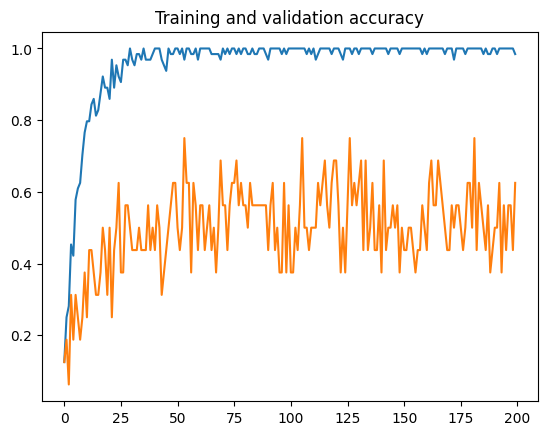

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

<Figure size 640x480 with 0 Axes>

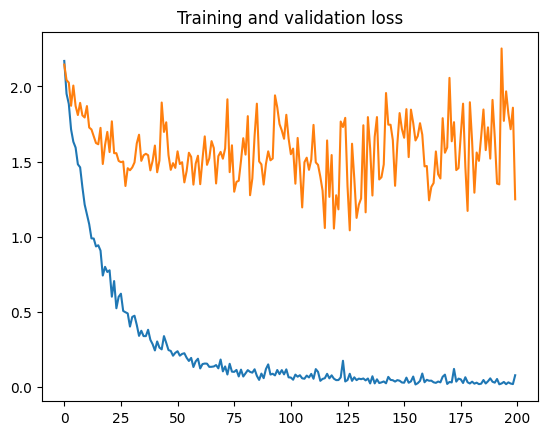

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.figure()

In [ ]:
# Save the model
#model.save('path/to/save/model')